## This notebook
- **Can we reconstruct a (weight) matrix solely by remembering its randomly down-projected outputs on a batch of randomly-generated data?** This could compress weight matrices in neural networks - only the seed of the randomly generated data and down-projection matrix are stored + the down-projected outputs. Possible application I'm currently thinking of is in **continual learning** - running gradient descent on memorized dynamics of the model for the random input (layer by layer w/out applying nonlinearities).
1. Initialize target weight matrix $W \isin \mathbb{R}^{d, d}$ and random input data $X \isin \mathbb{R}^{n, d}$ (normal distribution, mean 0, std 1)
2. Get outputs of the layer (simple linear projection, no nonlinearities): $X \cdot W^T\ =: h \isin \mathbb{R}^{n, d}$
3. Apply random down-projection $h \cdot W_{out}^T =: y \isin \mathbb{R}^{n, d_{y}}$ where $W_{out} \isin \mathbb{R}^{d_{y}, d}$ to reduce the memory footprint of this whole compression process further.
4. Initialize random weight matrix $\hat{W} \isin \mathbb{R}^{d, d}$ (same mean and std as $W$)
5. Run gradient descent (GD) on $\hat{W}$ to minimize loss $L = \frac{1}{n} \sum_{i=1}^{n} \left\| h_i - \hat{W} \cdot X_i^T \right\|_2^2$ or $L = \frac{1}{n} \sum_{i=1}^{n} \left\| y_i - W_{out} \cdot \hat{W} \cdot X_i^T \right\|_2^2$. The latter is for the case where we apply the down-projection to $h$. Alternatively use the normal equations (with pseudoinverses) to get the reconstruction (the code below does this).
6. Evaluate how close $W$ and $\hat{W}$ are and how close are their outputs $h$ and $y$. 

- **Result**: 
  - As could be expected, minimizing the loss $L$ using $h$'s is a classical least squares problem, hence once the number of random data points exceeds the feature dimension, reconstruction is almost perfect.
  - Minimizing the loss using $y$'s is a bit more tricky - more precisely, the reconstruction of $W$ is not satisfactory. Although MAE of $W$ is around 0.079, the MAE of $h$ can not get below 0.355 (which is too much for practical use from my pov). Details: the dimensions of $y$ are in this case $n$ x $10$ where $n$ is the number of random data points, feature dimension is 512 (so $W \isin \mathbb{R}^{512, 512}$, $y \isin \mathbb{R}^{n, 10}$). The dependency on $n$ can be seen below.

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

torch.set_printoptions(precision=3, linewidth=180)

### Utils

In [2]:
def optimize_reconstruction(X, y, h, W_hat, W_out, n_gd_steps, lr, print_every=1000):
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.SGD([W_hat], lr=lr)
    for gd_i in range(n_gd_steps):
        h_hat = X @ W_hat.T
        y_hat = h_hat @ W_out.T

        # use either h for the reconstruction (not much of a compression)
        # loss = loss_fn(h_hat, h)

        # or use y for the reconstruction
        loss = loss_fn(y_hat, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if print_every is not None and gd_i % print_every == print_every - 1:
            print(
                f"[{gd_i}/{n_gd_steps}] Loss in W: {loss.item():10f}"
                f"\n\t Loss in y:\t\t{loss_fn(y_hat, y).item():.10f}"
                f"\n\t Loss in h:\t\t{loss_fn(X @ W_hat.T, h).item():.10f}"
            )

    return W_hat

In [3]:
def plot_history(history, n_random_sample_to_test):
    fig, axes = plt.subplots(3, 2, figsize=(20, 18))

    # use log scale for the x-axis
    axes[0][0].plot(n_random_sample_to_test, history["mse_W"], c="r")
    axes[0][0].set_title("MSE in W")
    axes[0][0].set_xscale("log")
    axes[0][1].plot(n_random_sample_to_test, history["mae_W"], c="r")
    axes[0][1].set_title("MAE in W")
    axes[0][1].set_xscale("log")

    axes[1][0].plot(n_random_sample_to_test, history["mse_y"], c="r")
    axes[1][0].set_title("MSE in y")
    axes[1][0].set_xscale("log")
    axes[1][1].plot(n_random_sample_to_test, history["mae_y"], c="r")
    axes[1][1].set_title("MAE in y")
    axes[1][1].set_xscale("log")

    axes[2][0].plot(n_random_sample_to_test, history["mse_h"], c="r")
    axes[2][0].set_title("MSE in h")
    axes[2][0].set_xscale("log")
    axes[2][1].plot(n_random_sample_to_test, history["mae_h"], c="r")
    axes[2][1].set_title("MAE in h")
    axes[2][1].set_xscale("log")
    
    plt.show()

### Run

> Num of random samples: 1
	[END] MSE in W:		0.01002
	[END] MAE in W:		0.07987
	[END] MSE in y:		0.00000
	[END] MAE in y:		0.00000
	[END] MSE in h:		0.18269
	[END] MAE in h:		0.34474
> Num of random samples: 5
	[END] MSE in W:		0.01002
	[END] MAE in W:		0.07986
	[END] MSE in y:		0.00000
	[END] MAE in y:		0.00000
	[END] MSE in h:		0.21280
	[END] MAE in h:		0.37023
> Num of random samples: 10
	[END] MSE in W:		0.01002
	[END] MAE in W:		0.07987
	[END] MSE in y:		0.00000
	[END] MAE in y:		0.00000
	[END] MSE in h:		0.20202
	[END] MAE in h:		0.35920
> Num of random samples: 30
	[END] MSE in W:		0.01001
	[END] MAE in W:		0.07983
	[END] MSE in y:		0.00000
	[END] MAE in y:		0.00000
	[END] MSE in h:		0.20053
	[END] MAE in h:		0.35743
> Num of random samples: 50
	[END] MSE in W:		0.01001
	[END] MAE in W:		0.07980
	[END] MSE in y:		0.00000
	[END] MAE in y:		0.00000
	[END] MSE in h:		0.19745
	[END] MAE in h:		0.35415
> Num of random samples: 100
	[END] MSE in W:		0.00999
	[END] MAE in W:		0.07972
	

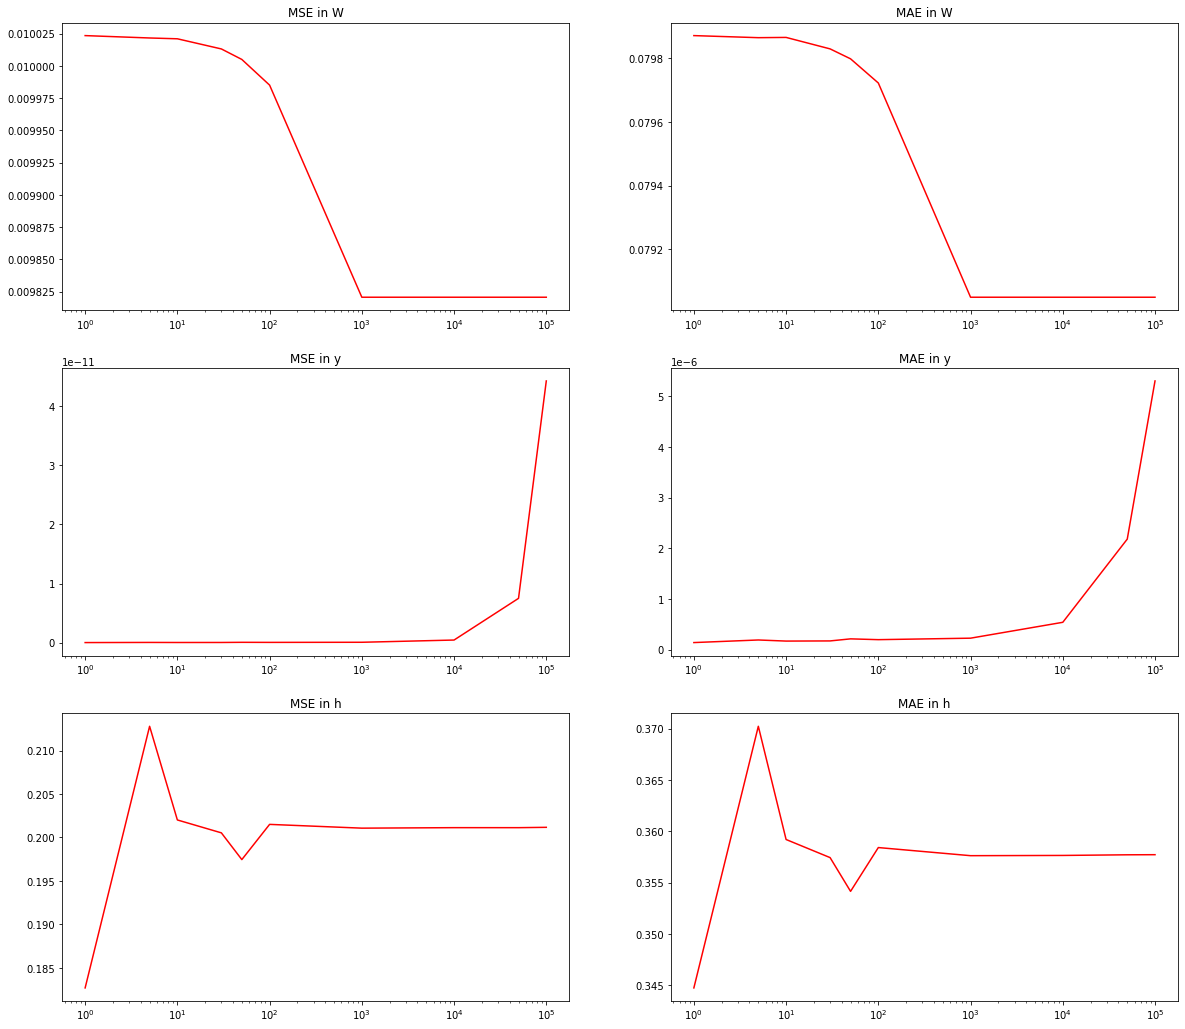

In [4]:
config = dict(
    dim=512, # dimension of the input (so W is dim x dim)
    X_mean=0,
    X_std=0.2,
    W_mean=0,
    W_std=0.1,
    W_out_mean=0,
    W_out_std=0.1,
    y_dim=10,
    
    n_random_samples_to_test=[1, 5, 10, 30, 50, 100, 1_000, 10_000, 50_000, 100_000],
    n_tests_per_num_of_samples=3,
    n_gd_steps=5_000,
    lr=0.01,
    print_every=None,
)

### target weight matrix
W = torch.normal(mean=config["W_mean"], std=config["W_std"], size=(config["dim"], config["dim"]))

### W_out (make it so that it has orthogonal columns)
W_out = nn.Linear(config["dim"], config["y_dim"], bias=False)
W_out.weight.data = torch.normal(mean=config["W_out_mean"], std=config["W_out_std"], size=(config["y_dim"], config["dim"]))
W_out = torch.nn.utils.parametrizations.orthogonal(W_out).weight.data

history = {"mse_W": [], "mae_W": [], "mse_y": [], "mae_y": [], "mse_h": [], "mae_h": []}
for n_random_samples in config["n_random_samples_to_test"]:
    print(f"> Num of random samples: {n_random_samples}")

    test_results = dict().fromkeys(history.keys())
    for test_i in range(config["n_tests_per_num_of_samples"]):
        ### random batch of data
        X = torch.normal(mean=config["X_mean"], std=config["X_std"], size=(n_random_samples, config["dim"]))
        
        ### outputs
        h = X @ W.T
        y = h @ W_out.T

        ### optimize reconstruction of W
        # use either h for the reconstruction (not much of a compression...)
        # W_hat = torch.linalg.lstsq(X, h).solution.T
        
        # or use y for the reconstruction (down-projection of h)
        W_hat = torch.linalg.lstsq(X, y @ torch.linalg.pinv(W_out).T).solution.T ### use y for reconstruction (down-projection of h)
        
        # ... or run (almost) manually gradient descent - much slower
        # W_hat = torch.normal(mean=config["W_mean"], std=config["W_std"], size=(config["dim"], config["dim"]), requires_grad=True)
        # W_hat = optimize_reconstruction(X=X, y=y, h=h, W_hat=W_hat, W_out=W_out, n_gd_steps=config["n_gd_steps"], lr=config["lr"], print_every=config["print_every"])
        
        ### log
        test_results["mse_W"] = F.mse_loss(W_hat, W).item()
        test_results["mae_W"] = (W_hat - W).abs().mean().item()
        test_results["mse_y"] = F.mse_loss(y, (X @ W_hat.T) @ W_out.T).item()
        test_results["mae_y"] = (y - (X @ W_hat.T) @ W_out.T).abs().mean().item()
        test_results["mse_h"] = F.mse_loss(h, X @ W_hat.T).item()
        test_results["mae_h"] = (h - X @ W_hat.T).abs().mean().item()
    
    ### log
    print(
        f"\t[END] MSE in W:\t\t{np.mean(test_results['mse_W']):.5f}"
        f"\n\t[END] MAE in W:\t\t{np.mean(test_results['mae_W']):.5f}"
        f"\n\t[END] MSE in y:\t\t{np.mean(test_results['mse_y']):.5f}"
        f"\n\t[END] MAE in y:\t\t{np.mean(test_results['mae_y']):.5f}"
        f"\n\t[END] MSE in h:\t\t{np.mean(test_results['mse_h']):.5f}"
        f"\n\t[END] MAE in h:\t\t{np.mean(test_results['mae_h']):.5f}"
    )

    for k, v in test_results.items():
        history[k].append(np.mean(v))

### plot history
plot_history(history, config["n_random_samples_to_test"])